In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [7]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist', 'Copy of Baseline Mnist 5*5.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/Copy of Baseline Mnist 5*5.csv


In [8]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [9]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 2.515, "branch2.0FLOPS": 2.515, "branch3.0FLOPS": 2.515, "totalFLOPS": 17.182}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [10]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [11]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [12]:
combined_avg_norm_var_acc_integrated_gradients.to_csv(save_folder+"/Baseline Mnist 5*5 ig.csv")
combined_avg_norm_var_acc_integrated_gradients=pd.read_csv(save_folder+"/Baseline Mnist 5*5 ig.csv")

In [13]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_3_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_integrated_gradients

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.345895,0.354027,0.300078,0.048347,0.108412,0.085196,0.080652,93.383556,94.777333,2.515,2.515,2.515,17.182,94.777333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.366506,0.337249,0.296245,0.033267,0.078431,0.064633,0.058777,92.680778,95.220667,2.515,2.515,2.515,17.182,95.220667
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.368820,0.337212,0.293968,0.024942,0.059889,0.057182,0.047338,91.511778,94.700000,2.515,2.515,2.515,17.182,94.700000
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.359885,0.349266,0.290849,0.047341,0.102615,0.075685,0.075214,93.429000,96.331333,2.515,2.515,2.515,17.182,96.331333
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.363454,0.340846,0.295700,0.021376,0.069346,0.060063,0.050262,92.962778,96.159333,2.515,2.515,2.515,17.182,96.159333
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.365947,0.334691,0.299362,0.021776,0.052034,0.049225,0.041011,91.983000,95.974667,2.515,2.515,2.515,17.182,95.974667
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.354326,0.360141,0.285533,0.085378,0.127465,0.113904,0.108916,92.776222,94.032000,2.515,2.515,2.515,17.182,94.032000
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.364169,0.352012,0.283819,0.047438,0.106194,0.094331,0.082654,92.740000,94.572000,2.515,2.515,2.515,17.182,94.572000
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.356556,0.351141,0.292303,0.038145,0.076096,0.069702,0.061314,92.186222,94.758667,2.515,2.515,2.515,17.182,94.758667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.358549,0.338499,0.302952,0.082028,0.158248,0.143509,0.127928,92.767000,95.686000,2.515,2.515,2.515,17.182,95.686000


# Graph

In [14]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [15]:
filtered_integrated_gradients.to_csv(save_folder+"/Baseline Mnist 5*5 ig ave var.csv")

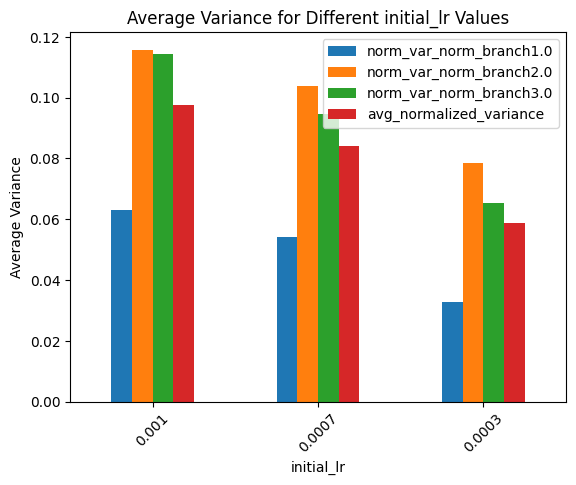

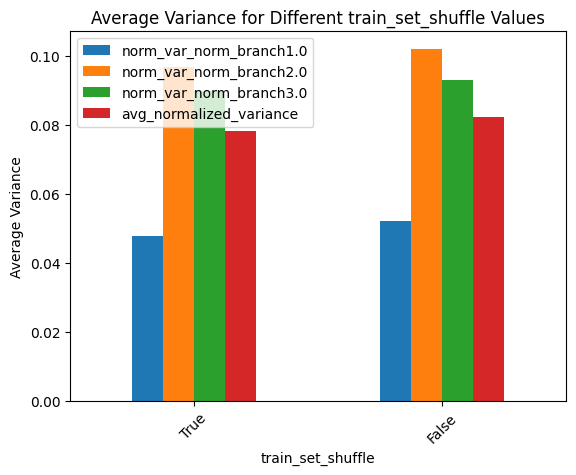

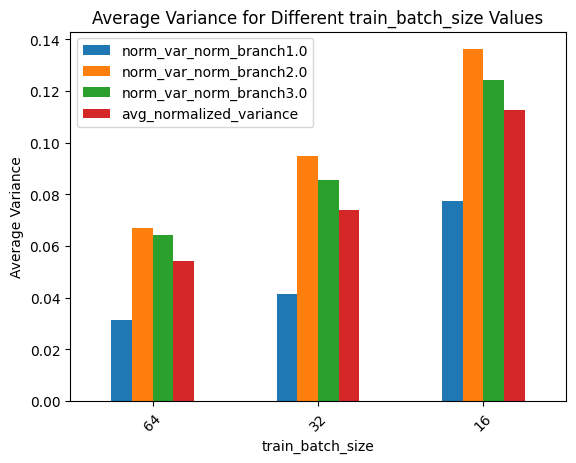

In [16]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_integrated_gradients, hyperparam, variables)

# T test

In [17]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [18]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.7056610774080794 P-value: 0.49650824279732797


In [19]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.8886554002314966 P-value: 0.08825722113298447


In [20]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 2.3446398456321136 P-value: 0.041013824489672564


train_set_shuffle

In [21]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.27572297686844105 P-value: 0.7862901711364196


train_batch_size

In [22]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.4117214424641067 P-value: 0.036575591169038704


In [23]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -4.674061348107725 P-value: 0.000875382520463149


In [24]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.7266584595280485 P-value: 0.0213153150023658


# Paired T test

In [25]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [26]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [27]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [28]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [29]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.057572982319357 0.0557521236694962
0.0833917278039812 0.0683856981302585
0.1437094125789748 0.1279282386202413
0.0618689221099597 0.0613142865620011
0.1003085508526272 0.0826544575263315
0.1394437300775989 0.1089157712748989
T-statistic: 2.9855080097672757 One-sided P-value: 0.015302578182535527


In [30]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0557521236694962 0.0410114397367236
0.0683856981302585 0.0502617985402831
0.1279282386202413 0.0752135445173375
0.0613142865620011 0.0473376739581374
0.0826544575263315 0.0587769363432206
0.1089157712748989 0.0806517973525848
T-statistic: 4.266308720370903 One-sided P-value: 0.0039833809765778124


In [31]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.057572982319357 0.0410114397367236
0.0833917278039812 0.0502617985402831
0.1437094125789748 0.0752135445173375
0.0618689221099597 0.0473376739581374
0.1003085508526272 0.0587769363432206
0.1394437300775989 0.0806517973525848
T-statistic: 4.3382877173229435 One-sided P-value: 0.003720456330527337


train_set_shuffle

In [32]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.057572982319357 0.0618689221099597
0.0833917278039812 0.1003085508526272
0.1437094125789748 0.1394437300775989
0.0557521236694962 0.0613142865620011
0.0683856981302585 0.0826544575263315
0.1279282386202413 0.1089157712748989
0.0410114397367236 0.0473376739581374
0.0502617985402831 0.0587769363432206
0.0752135445173375 0.0806517973525848
T-statistic: -1.195566658377734 One-sided P-value: 0.8669503610018023


train_batch_size

In [33]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0833917278039812 0.057572982319357
0.1003085508526272 0.0618689221099597
0.0683856981302585 0.0557521236694962
0.0826544575263315 0.0613142865620011
0.0502617985402831 0.0410114397367236
0.0587769363432206 0.0473376739581374
T-statistic: 4.364865457062117 One-sided P-value: 0.003628493495538372


In [34]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.1437094125789748 0.0833917278039812
0.1394437300775989 0.1003085508526272
0.1279282386202413 0.0683856981302585
0.1089157712748989 0.0826544575263315
0.0752135445173375 0.0502617985402831
0.0806517973525848 0.0587769363432206
T-statistic: 5.4185862202951585 One-sided P-value: 0.0014492024184609641


In [35]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.1437094125789748 0.057572982319357
0.1394437300775989 0.0618689221099597
0.1279282386202413 0.0557521236694962
0.1089157712748989 0.0613142865620011
0.0752135445173375 0.0410114397367236
0.0806517973525848 0.0473376739581374
T-statistic: 6.214883399196987 One-sided P-value: 0.0007881364629887965


#layer feature attribution rank frequency comparison

In [36]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'integrated_gradients']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-13-4ef74943cc56>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.1,branch2.1,branch3.1,train accuracy epoch0,...,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,500.255756,246.803773,163.657415,91.956667,...,integrated_gradients,0,2.515,2.515,2.515,17.182,0.549299,0.270999,0.179702,95.32
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,232.539410,244.853985,263.080771,93.383333,...,integrated_gradients,1,2.515,2.515,2.515,17.182,0.314041,0.330672,0.355287,95.47
5,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,220.647591,546.907169,171.739247,92.821667,...,integrated_gradients,2,2.515,2.515,2.515,17.182,0.234908,0.582253,0.182839,96.53
7,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,272.445984,665.079018,109.259504,92.226667,...,integrated_gradients,3,2.515,2.515,2.515,17.182,0.260269,0.635354,0.104376,96.37
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,422.548661,53.697245,471.003323,92.398333,...,integrated_gradients,4,2.515,2.515,2.515,17.182,0.446080,0.056688,0.497233,96.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,285.920852,161.316475,322.450325,93.388333,...,integrated_gradients,10,2.515,2.515,2.515,17.182,0.371476,0.209587,0.418937,94.22
533,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,249.954207,275.720132,293.593464,93.128333,...,integrated_gradients,11,2.515,2.515,2.515,17.182,0.305095,0.336545,0.358361,93.52
535,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,322.433379,195.161457,402.004255,93.538333,...,integrated_gradients,12,2.515,2.515,2.515,17.182,0.350624,0.212224,0.437152,94.97
537,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,377.179535,296.594226,235.053180,93.615000,...,integrated_gradients,13,2.515,2.515,2.515,17.182,0.415018,0.326348,0.258634,95.69


In [37]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-37-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


321    85
213    61
231    57
123    33
312    25
132     9
Name: rank_combination, dtype: int64